In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as grs
from brian2 import us, ms, nA, pA, defaultclock
from utils.plotting import plot_sample, plot_input_layer_with_membrane_potential, plot_hennequin_reservoir_raster, plot_currents_distributions
from utils.plotting import plot_hennequin_reservoir_raster_without_input
from utils.modulator import AsynchronousDeltaModulator, modulate
from utils.reservoir import getTauCurrent
from spiking_radio_reservoir import setup_hennequin_connectivity, setup_generator, setup_input_layer, setup_reservoir_layer, init_network

In [2]:
np.random.seed(42)

# Phase detection

We want to detect different phase shifts between 2 sinusoidal input streams I and Q. To do this we build a reservoir of $N$ neurons with random excitatory and inhibitory synapsis. 

## Input

The input consists of two streams I and Q which differ only by global phase $\phi$:

$$
I(t) = \sin(2\pi t),~ Q = sin(2\pi t + \phi(t))
$$

where $\phi$ takes values from a finite set of possible phase shifts.

In [3]:
def I(t):
    return np.sin(2*np.pi*f*t)

def Q(t):
    return np.sin(2*np.pi*f*t + phi)

In [4]:
T = 2*128 # duration of sampling [us]
num_periods = 8 # duration of new interval between samples after resampling [us]
f = num_periods/T # stimulation frequency [Hz]
time_sample = np.arange(T)

Text(0.5, 0, 'Time [us]')

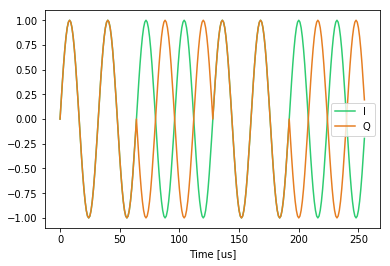

In [5]:
phi = [0.0 for i in range(int(T/4))] + [np.pi for i in range(int(T/4))] + [0.0 for i in range(int(T/4))] + [np.pi for i in range(int(T/4))] 
plt.figure(figsize=(6, 4))
plt.plot(time_sample, I(time_sample), color='#2ecc71', label='I')
plt.plot(time_sample, Q(time_sample), color='#e67e22', label='Q')
plt.legend(loc='best')
plt.xlabel('Time [us]')

## Spike trains

Spikes are obtained from the input streams through a AsynchronousDeltaModulator, which generates an UP and a DN channel for each stream.

In [6]:
settings = {
    'time_sample': np.arange(T),
    'thrup': 0.1,
    'thrdn': 0.1,
    'resampling_factor': 200,
    'stretch_factor': 1000
}

In [7]:
modulators = [
    AsynchronousDeltaModulator(settings['thrup'], settings['thrdn'], settings['resampling_factor']),
    AsynchronousDeltaModulator(settings['thrup'], settings['thrdn'], settings['resampling_factor'])
]

In [8]:
sample = np.array([I(settings['time_sample']), Q(settings['time_sample'])])
indices, times, time_stim, signal = modulate(modulators[0], modulators[1], settings['time_sample'], \
                                             sample, resampling_factor=settings['resampling_factor'], \
                                             stretch_factor=settings['stretch_factor'])

In [9]:
times = times*us
time_stim = time_stim*us
duration = 2*T*ms
bins = [0*ms]+[int(T/4)*(i+1)*settings['stretch_factor']*us for i in range(4)]

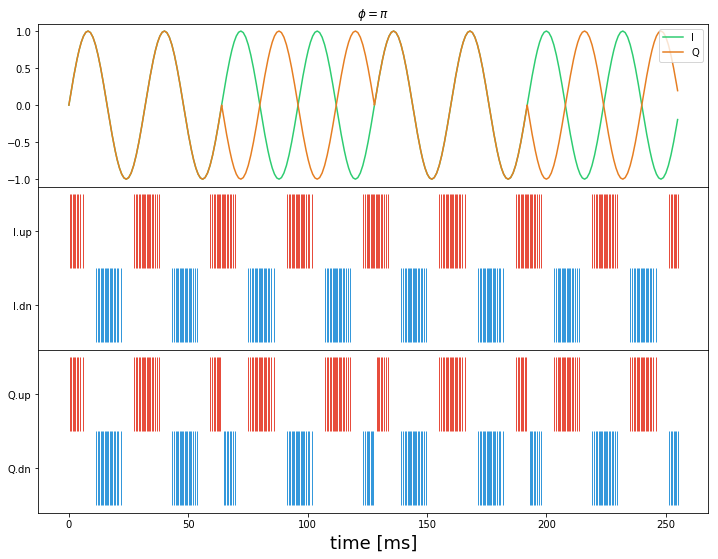

In [10]:
title = r"$\phi=\pi$"
plot_sample(signal, time_stim, indices, times, title, figsize=(12, 9))

## Reservoir

In [11]:
params = {
    'wGen': 500,
    'wInp': 500,
    'pIR': 0.07,
    'pE_local': 0.5,
    'pI_local': 1.0,
    'k': 3,
    'DoC': 0.2,
    'loc_wResE': 120,
    'scale_wResE': 20,
    'loc_wResI': -200,
    'scale_wResI': 40,
    'Ninp': 4,
    'N': 800,
    'Ngx': 20,
    'Ngy': 20
}
connectivity = setup_hennequin_connectivity(params['N'], params['pIR'], params['Ngx'], params['Ngy'], \
    params['pE_local'], params['pI_local'], params['k'], params['DoC'], \
    params['loc_wResE'], params['scale_wResE'], params['loc_wResI'], params['scale_wResI'])

In [12]:
num_syn = len(connectivity['res_res']['w'])
params['currents'] = {
    'gInp': {
        'Iahp': 0.5*pA,
        'Itau': getTauCurrent(5*ms),
        'Ispkthr': 0.2*nA
    },
    'gRes': {
        'Iahp': 0.5*pA,
        # 'Itauahp': getAhpTauCurrent(50*ms),
        'Itau': np.random.normal(loc=getTauCurrent(20*ms)/pA, scale=1, size=params['N'])*pA,
        'Ispkthr': 0.2*nA
    },
    'sInpRes': {
        'Ie_tau': getTauCurrent(7*ms)
    },
    'sResRes': {
        'Ie_tau': np.random.normal(loc=getTauCurrent(7*ms)/pA, scale=1, size=num_syn)*pA,
        'Ii_tau': np.random.normal(loc=getTauCurrent(7*ms)/pA, scale=1, size=num_syn)*pA,
    }
}

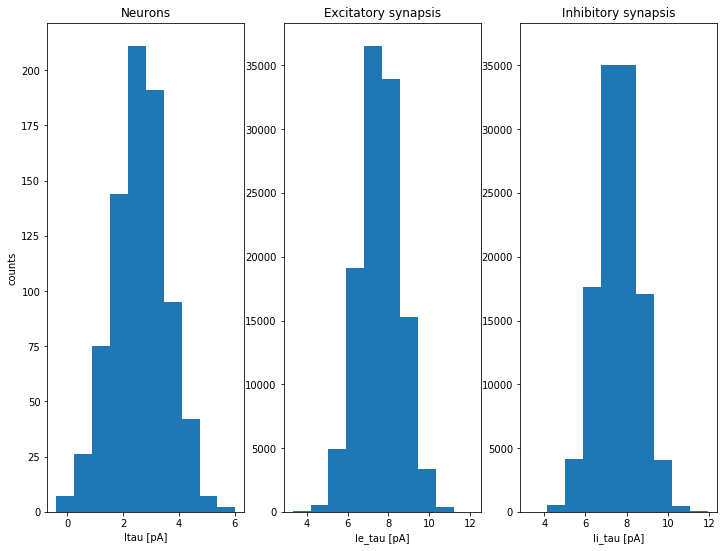

In [13]:
plot_currents_distributions(params['currents'])

In [14]:
components = {'generator': None, 'layers': {}, 'synapses': {}, 'monitors': {}}
components = setup_generator(components)
components = setup_input_layer(components, connectivity, params['Ninp'], params['currents'], params['wGen'])
components = setup_reservoir_layer(components, connectivity, params['N'], params['currents'], params['wInp'])
components['layers']['run_reg_gRes'] = components['layers']['gRes'].run_regularly("Imem=0*pA", dt=duration)
components['synapses']['run_reg_sResRes'] = components['synapses']['sResRes'].run_regularly("""
                                                                                                Ie_syn=Io_syn
                                                                                                Ii_syn=Io_syn
                                                                                            """, dt=duration)

In [15]:
network = init_network(components, indices, times)    
defaultclock.dt = 50*us
network.run(duration)

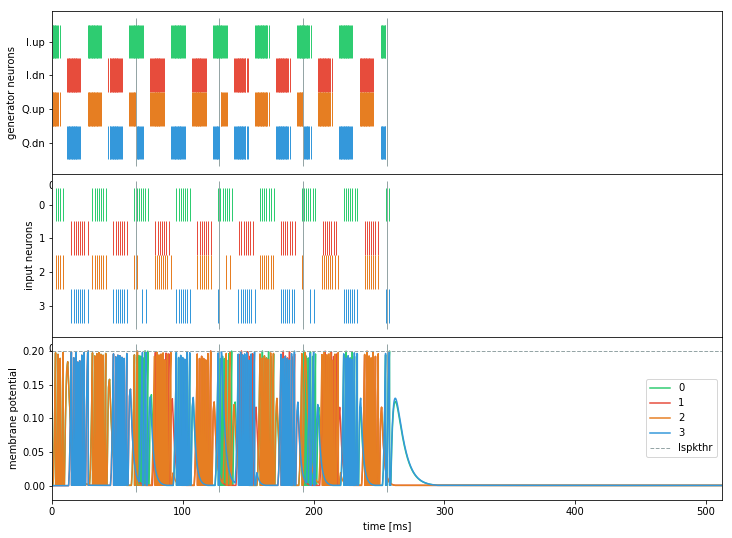

In [16]:
plot_input_layer_with_membrane_potential(indices, times, network, duration, bins=bins[1:])

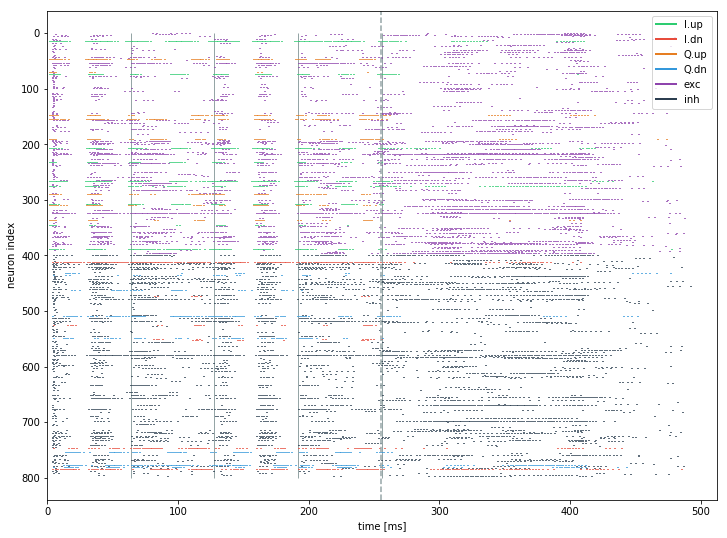

In [17]:
plot_hennequin_reservoir_raster(connectivity, params, network, times, duration, bins=bins[1:])

# Readout analysis

Let's readout the activity of the reservoir in order to find out if the reservoir is projecting the input patterns into different high-dimensional states. To do this we need to:
1. get the readout and bin it according to the time scale of the input patterns
2. filter out the neurons that receive input
4. apply dimensionality reduction/clustering to extract a characteristic pattern of the binned readout

## Step 1.

In [18]:
X = []
for i in range(len(bins)-1):
    idx = np.logical_and(network['mRes'].t>=bins[i], network['mRes'].t<bins[i+1])
    X.append([network['mRes'].t[idx], network['mRes'].i[idx]])

## Step 2.

In [19]:
input_neurons_Iup = connectivity['inp_res']['j'][connectivity['inp_res']['i']==0]
input_neurons_Idn = connectivity['inp_res']['j'][connectivity['inp_res']['i']==1]
input_neurons_Qup = connectivity['inp_res']['j'][connectivity['inp_res']['i']==2]
input_neurons_Qdn = connectivity['inp_res']['j'][connectivity['inp_res']['i']==3]
mask = np.zeros(params['N'])
mask[input_neurons_Iup] = 1.0
mask[input_neurons_Idn] = 1.0
mask[input_neurons_Qup] = 1.0
mask[input_neurons_Qdn] = 1.0
reservoir_neurons = np.ma.array(np.arange(params['N']), mask=mask)

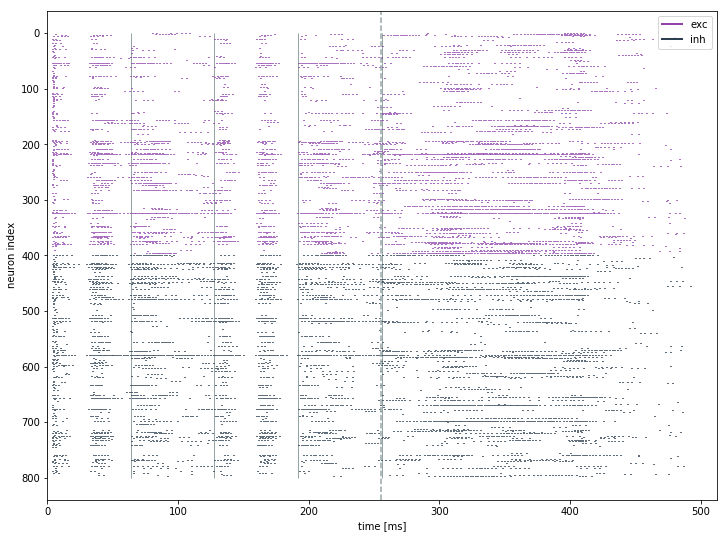

In [20]:
plot_hennequin_reservoir_raster_without_input(connectivity, params, network, times, duration, bins=bins)

In [21]:
input_neurons = np.concatenate([input_neurons_Iup, input_neurons_Idn, input_neurons_Qup, input_neurons_Qdn]) 

In [22]:
for x in X:
    mask = np.zeros(len(x[0]))
    for n in input_neurons:
        idx = np.where(x[1]==n)[0]
        mask[idx] = 1.0
    x = [np.ma.array(x[0], mask=mask), np.ma.array(x[1], mask=mask)]

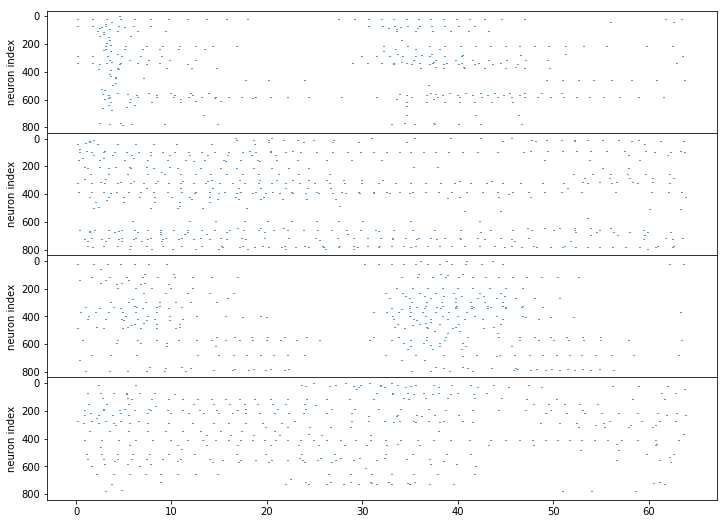

In [23]:
fig = plt.figure(figsize=(12, 9))
grid = grs.GridSpec(len(X), 1, wspace=0.0, hspace=0.0)
for (i, x) in enumerate(X):
    positions = []
    for n in range(params['N']):
        idx = np.where(x[1]==n)[0]
        positions.append(x[0][idx]/ms-bins[i]/ms)
    ax = plt.Subplot(fig, grid[i])
    ax.eventplot(positions)
    ax.invert_yaxis()
    ax.set_ylabel("neuron index")
    fig.add_subplot(ax)

## Step 3.

In [24]:
H = []
for (i, x) in enumerate(X):
    h, _, _ = np.histogram2d(x[0]/ms, x[1], bins=[12, params['N']], range=[[bins[i]/ms, bins[i+1]/ms], [0, params['N']]])
    H.append(h)

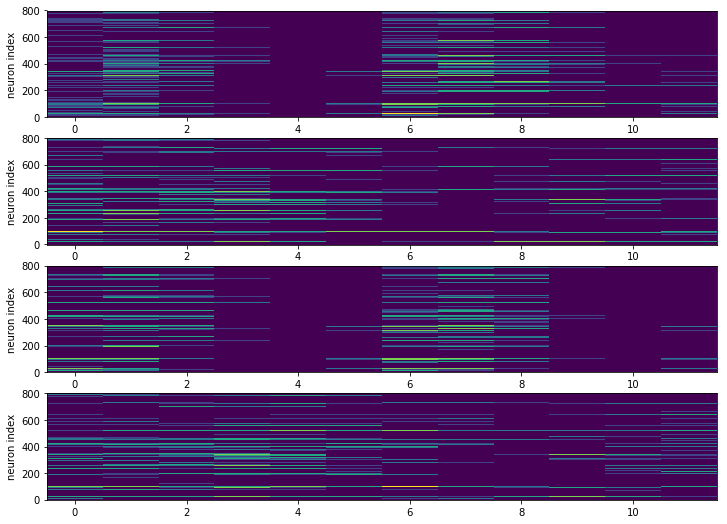

In [25]:
fig = plt.figure(figsize=(12, 9))
grid = grs.GridSpec(len(X), 1, wspace=0.0, hspace=0.2)
for (i, h) in enumerate(H):
    ax = plt.Subplot(fig, grid[i])
    ax.imshow(h.T, origin='low', interpolation='nearest', aspect='auto')
    ax.set_ylabel("neuron index")
    fig.add_subplot(ax)